# Object Detection API Demo

<table align="left"><td>
  <a target="_blank"  href="https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

Welcome to the [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image.

> **Important**: This tutorial is to help you through the first step towards using [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to build models. If you just just need an off the shelf model that does the job, see the [TFHub object detection example](https://colab.sandbox.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).

# Setup

Important: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md). This notebook includes only what's necessary to run in Colab.

### Install

In [0]:
#!pip install -U --pre tensorflow=="2.*"

Make sure you have `pycocotools` installed

In [0]:
#!pip install pycocotools

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [0]:
if False:
    import os
    import pathlib


    if "models" in pathlib.Path.cwd().parts:
      while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
    elif not pathlib.Path('models').exists():
      !git clone --depth 1 https://github.com/tensorflow/models

Compile protobufs and install the object_detection package

In [0]:
if False:
    %%bash
    cd models/research/
    protoc object_detection/protos/*.proto --python_out=.

In [2]:
 if False:
    %%bash 
    cd models/research
    pip install .

SyntaxError: invalid syntax (<ipython-input-2-151d3ff21e30>, line 3)

### Imports

In [1]:
import os
import pathlib

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [3]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [4]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## Loader

In [5]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
# List of the strings that is used to add correct label for each box.
#PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
#PATH_TO_LABELS = 'data/mscoco_label_map.pbtxt'
PATH_TO_LABELS = 'data/vipir_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity we will test on 2 images:

In [7]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
#PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
#PATH_TO_TEST_IMAGES_DIR = pathlib.Path('test_images')
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('../images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
#TEST_IMAGE_PATHS

# Detection

Load an object detection model:

In [8]:
model_name = 'vipir_detector'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Check the model's input signature, it expects a batch of 3-color images of type uint8: 

In [9]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


And retuns several outputs:

In [10]:
detection_model.output_dtypes

{'num_detections': tf.float32,
 'detection_boxes': tf.float32,
 'raw_detection_boxes': tf.float32,
 'detection_features': tf.float32,
 'detection_scores': tf.float32,
 'raw_detection_scores': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'detection_classes': tf.float32}

In [11]:
detection_model.output_shapes

{'num_detections': TensorShape([None]),
 'detection_boxes': TensorShape([None, 300, 4]),
 'raw_detection_boxes': TensorShape([None, 300, 4]),
 'detection_features': TensorShape([None, None, None, None, None]),
 'detection_scores': TensorShape([None, 300]),
 'raw_detection_scores': TensorShape([None, 300, 2]),
 'detection_multiclass_scores': TensorShape([None, 300, 2]),
 'detection_classes': TensorShape([None, 300])}

Add a wrapper function to call the model, and cleanup the outputs:

In [12]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [13]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

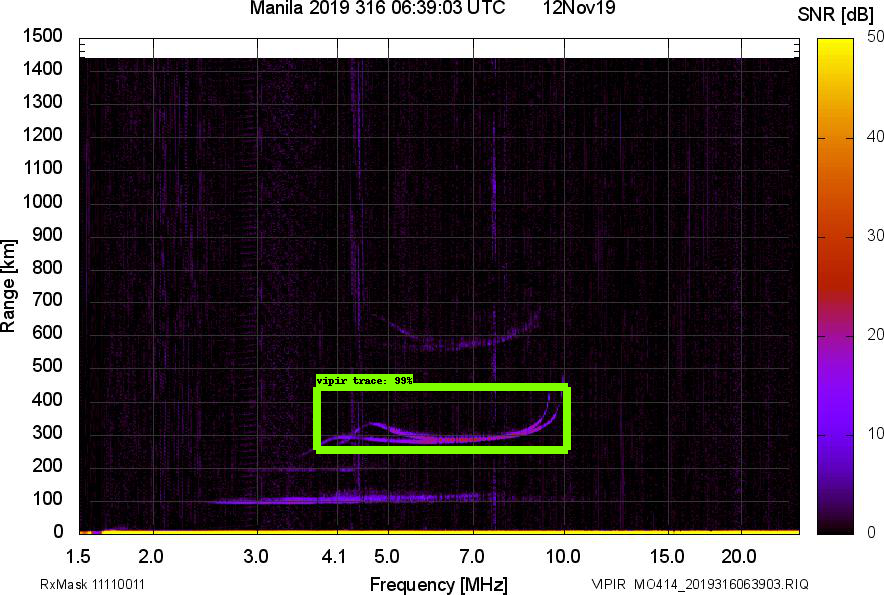

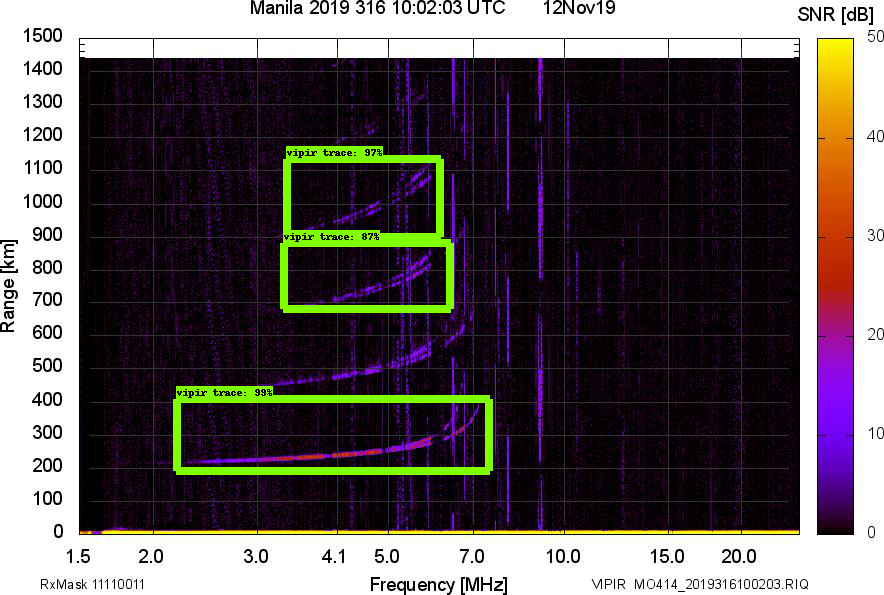

In [14]:
for image_path in TEST_IMAGE_PATHS[20:22]:
  show_inference(detection_model, image_path)


In [15]:
ip = TEST_IMAGE_PATHS[21]

In [16]:
image = Image.open(ip)
image_np = np.array(image)
  # Actual detection.
output_dict = run_inference_for_single_image(detection_model, image_np)

In [17]:
#output_dict

In [18]:
output_dict.keys()

dict_keys(['detection_multiclass_scores', 'detection_classes', 'detection_boxes', 'raw_detection_boxes', 'detection_features', 'detection_scores', 'raw_detection_scores', 'num_detections'])

In [19]:
len(output_dict['detection_classes'])

100

In [20]:
category_index[1]['name']

'vipir trace'

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline


Text(0.5, 1.0, 'NP Image')

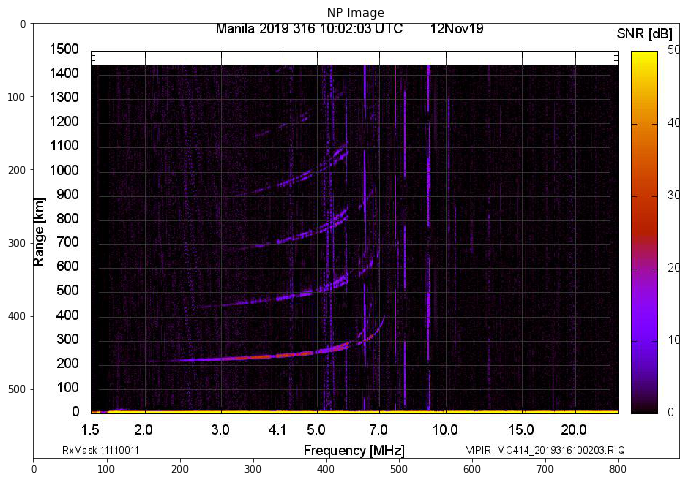

In [22]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(image_np)
ax.set_title('NP Image')

Text(0.5, 1.0, 'Plain Image')

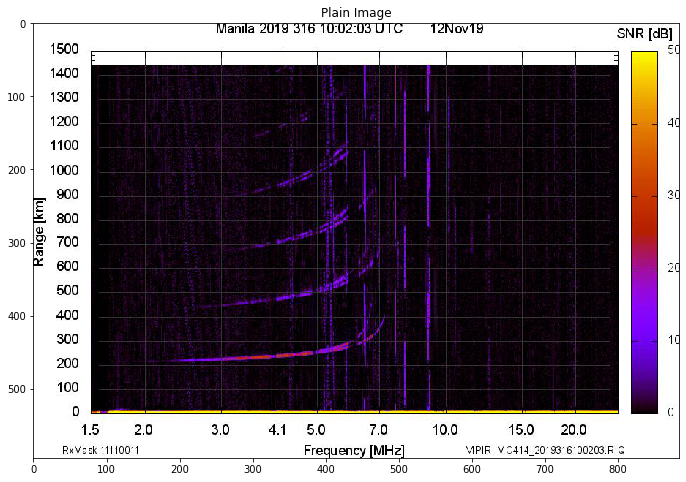

In [23]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(image)
ax.set_title('Plain Image')

In [24]:
output_dict['detection_boxes'][0]

array([0.67193556, 0.19970013, 0.7909243 , 0.5537134 ], dtype=float32)

In [25]:
import matplotlib.patches as patches

In [26]:
output_dict['detection_boxes'][0]

array([0.67193556, 0.19970013, 0.7909243 , 0.5537134 ], dtype=float32)

```
def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color='red',
                                       thickness=4,
                                       display_str_list_list=()):
  """Draws bounding boxes on image (numpy array).

  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: list of list of strings.
                           a list of strings for each bounding box.
                           The reason to pass a list of strings for a
                           bounding box is that it might contain
                           multiple labels.
```

In [27]:
vis_util.draw_bounding_boxes_on_image_array(image_np, output_dict['detection_boxes'][0:3])

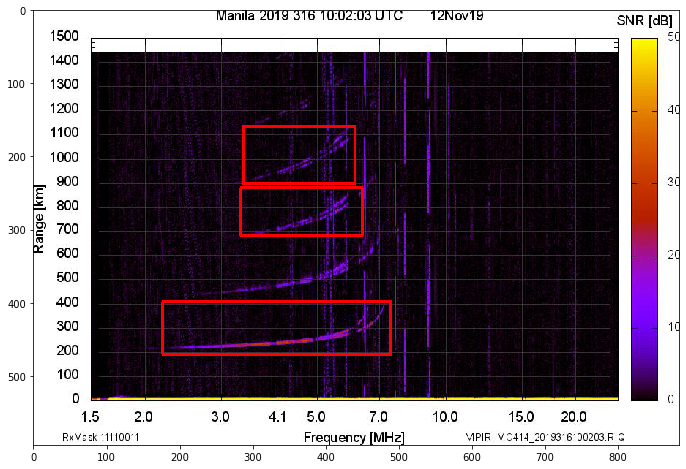

In [28]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(image_np)

In [29]:
ip

PosixPath('../images/MO414_2019316100203_SNR.jpg')

In [30]:
test_path = '../annotations/test.txt'
with open(test_path) as f:
    file_text = f.readlines()
file_list = [f.split(' ')[0] for f in file_text]

In [31]:
#file_list

In [32]:
from xml.etree import ElementTree as ET

In [33]:
imagexmls = [ET.parse('../annotations/xmls' + os.sep + xmlfile+'.xml') \
             for xmlfile in file_list]

In [34]:
imagexmls[3]

In [35]:
def get_imgpath(imgxml):
    root_element = imgxml.getroot()
    folder = root_element.find('folder')
    filename = root_element.find('filename')
    
    return '{0}/{1}'.format(folder.text, filename.text)

In [36]:
def get_bounding_boxes(xml):
    root_el = xml.getroot()
    objs = root_el.findall('object')
    boxes = {}
    for i,o in enumerate(objs):
        bbox = o.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes['box'+str(i)] = {'Origin':(xmin, ymin),
                              'xextent':xmax-xmin, 'yextent':ymax-ymin}
    return boxes

In [37]:
get_bounding_boxes(imagexmls[3])

{'box0': {'Origin': (190, 196), 'xextent': 195, 'yextent': 164}}

```
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
```

In [38]:
get_imgpath(imagexmls[3])

'images/WI937_2019061144803_SNR.jpg'

In [39]:
os.getcwd()

'/home/kevin/NOAA4/TensorFlow/models/research/object_detection'

```
    
image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))
```

In [40]:
def show_test_image(model, imgxml):
    img_path = '../'+get_imgpath(imgxml)
    image = Image.open(img_path)
    
    bboxes = get_bounding_boxes(imgxml)
    for bbox in bboxes:
        xmin = bboxes[bbox]['Origin'][0]
        ymin = bboxes[bbox]['Origin'][1]
        xmax = bboxes[bbox]['xextent']+xmin
        ymax = bboxes[bbox]['yextent']+ymin
        vis_util.draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax,
                                            color='white',
                                            use_normalized_coordinates=False)
    
    image_np = np.array(image)
    output_dict = run_inference_for_single_image(model, image_np)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
    
    
    fig = plt.figure(figsihttps://console.cloud.google.com/home/dashboard?project=obj-dect-260218ze=(12,8))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(image_np)

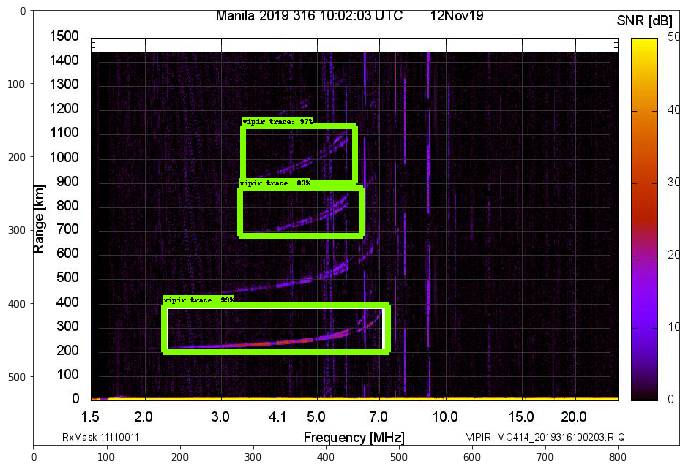

In [41]:
show_test_image(detection_model,imagexmls[18])

In [42]:
output_dict['detection_boxes'].shape

(100, 4)

In [43]:
def draw_box_on_axis(ax, ymin, xmin, ymax, xmax, use_normalized_coordinates=False,
                    color='red', linewidth=3):

    #yext = ymax-ymin if use_normalized_coordinates else ymin-ymax
    yext = ymax-ymin
    #print(f'xmin: {xmin}, xmax: {xmax}, ymin: {ymin}, ymax:{ymax}')
    #print(f'Origin X (xmin): {xmin}, Origin Y: {ymax}, Xextent: {xmax-xmin}, Yextent: {yext}')
    r = patches.Rectangle(( xmin, ymin), xmax-xmin, yext,facecolor='none',
                      edgecolor= color, linewidth=linewidth)
    if use_normalized_coordinates:
        r.set_transform(ax.transAxes)
    ax.add_patch(r)
    return ax
    

In [44]:
def show_detected_objects(ax, model, imgxml, threshold=0.75):

    img_path = '../'+get_imgpath(imgxml)
    image = Image.open(img_path)

    image_np = np.array(image)
    output_dict = run_inference_for_single_image(detection_model, image_np)

    ax.imshow(image_np)
    ax.set_title('Detected Traces')
    ax.set_xticks([])
    ax.set_yticks([])

    obs = output_dict['detection_scores'] >= threshold
    for box in output_dict['detection_boxes'][obs]:
        ymin = 1.0-box[0] #flip yaxis
        xmin = box[1]
        ymax = 1.0-box[2] #flip yaxis
        xmax = box[3]
        #print(f'xmin: {xmin}, xmax: {xmax}, ymin: {ymin}, ymax: {ymax}')
        draw_box_on_axis(ax, ymin, xmin, ymax, xmax, use_normalized_coordinates=True)


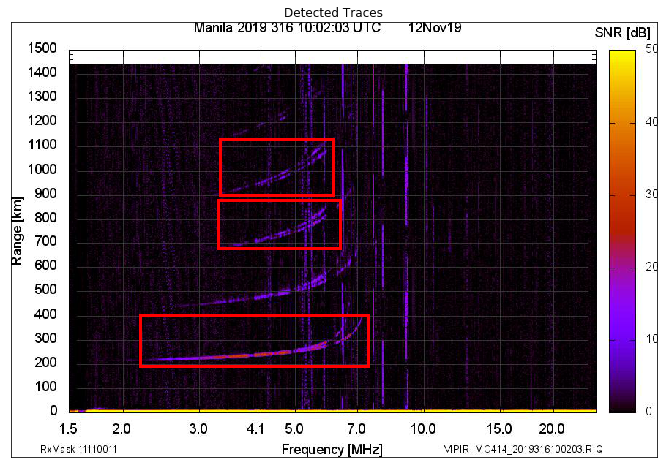

In [45]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

show_detected_objects(ax, detection_model, imagexmls[18])

plt.show()

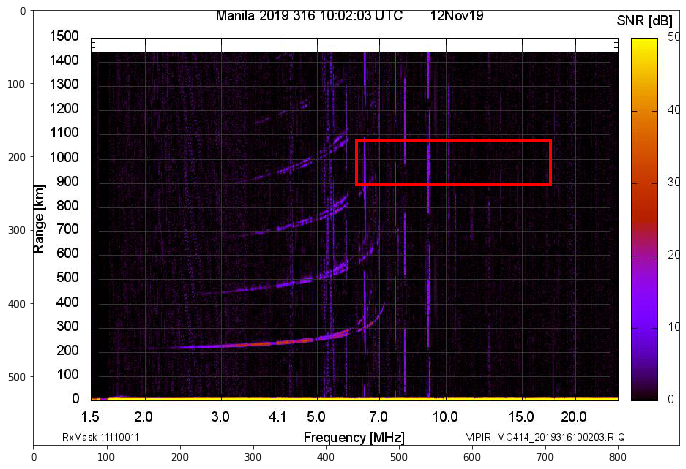

In [46]:
image = Image.open(ip)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(image)
xmin=0.5
xmax =0.8
ymin=0.6
ymax=0.7

draw_box_on_axis(ax, ymin, xmin, ymax, xmax, use_normalized_coordinates=True)

In [47]:
def show_ground_truth_image(ax, imgxml):
    img_path = '../'+get_imgpath(imgxml)
    image = Image.open(img_path)
    
    ax.imshow(image)
    ax.set_title('Ground Truth')
    ax.set_xticks([])
    ax.set_yticks([])
    
    bboxes = get_bounding_boxes(imgxml)
    for bbox in bboxes:
        xmin = bboxes[bbox]['Origin'][0]
        xmax = bboxes[bbox]['xextent']+xmin
        
        #images, so y values need to be inverted        
        ymin = bboxes[bbox]['Origin'][1]
        yext = bboxes[bbox]['yextent']
        ymax = yext+ymin
        ymin = ymax - yext

        draw_box_on_axis(ax, ymin, xmin, ymax, xmax, 
                         color='white', use_normalized_coordinates=False)
    
    
    

```
    r = patches.Rectangle(( xmin, ymax), xmax-xmin, ymax-ymin,facecolor='none',
                      edgecolor= color, linewidth=linewidth)
```

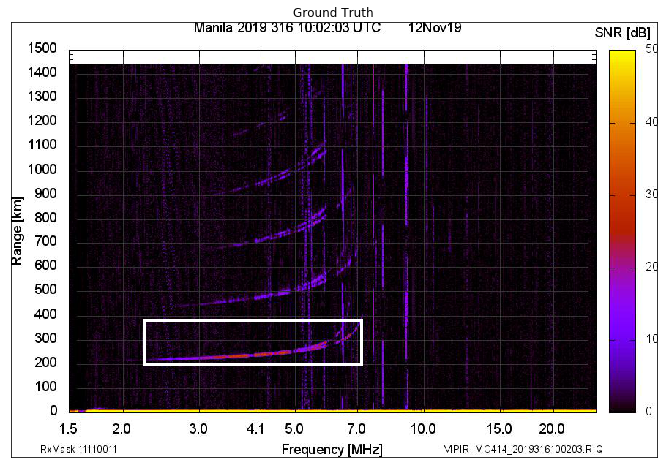

In [48]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

show_ground_truth_image(ax, imagexmls[18])

plt.show()

In [49]:
def before_and_after(imgxml):
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,2,1)
    show_ground_truth_image(ax, imgxml)

    ax = fig.add_subplot(1,2,2)
    show_detected_objects(ax, detection_model, imgxml)

    plt.tight_layout()

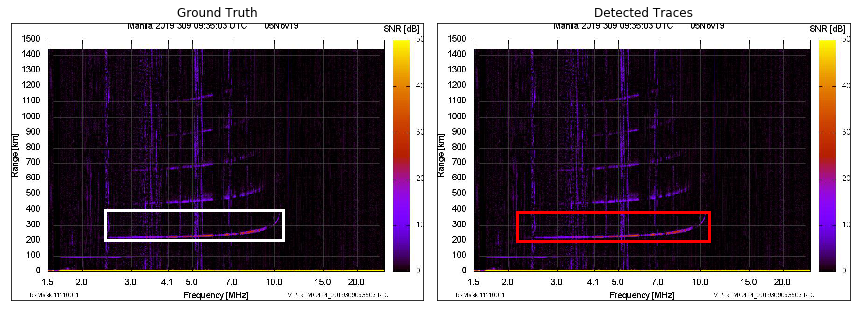

In [50]:
before_and_after(imagexmls[11])

In [58]:
def create_outputpath(imgxml):
    root_element = imgxml.getroot()
    folder = root_element.find('folder')
    filename = root_element.find('filename')
    
    return './traces_out/{0}.png'.format(filename.text.split('.')[0])

In [64]:
for imgxml in imagexmls:
    outpath = create_outputpath(imgxml)
    print (outpath)
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,2,1)
    show_ground_truth_image(ax, imgxml)

    ax = fig.add_subplot(1,2,2)
    show_detected_objects(ax, detection_model, imgxml)

    plt.tight_layout()
    fig.savefig(outpath, orientation='landscape',bbox_inches='tight')
    plt.close(fig)

./traces_out/MO414_2019313115603_SNR.png
./traces_out/SJJ18_2019150020601_SNR.png
./traces_out/WI937_2019317163402_SNR.png
./traces_out/WI937_2019061144803_SNR.png
./traces_out/WI937_2019051104003_SNR.png
./traces_out/MO414_2019318105903_SNR.png
./traces_out/SJJ18_2019002182601_SNR.png
./traces_out/WI937_2019051120603_SNR.png
./traces_out/MO414_2019317101303_SNR.png
./traces_out/SJJ18_2019261062801_SNR.png
./traces_out/WI937_2019148084602_SNR.png
./traces_out/MO414_2019309093503_SNR.png
./traces_out/MO414_2019315232903_SNR.png
./traces_out/WI937_2019284085402_SNR.png
./traces_out/WI937_2019259051603_SNR.png
./traces_out/WI937_2019284234803_SNR.png
./traces_out/SJJ18_2019002135202_SNR.png
./traces_out/SJJ18_2019248010001_SNR.png
./traces_out/MO414_2019316100203_SNR.png
./traces_out/SJJ18_2019071122002_SNR.png
./traces_out/MO414_2019315195603_SNR.png
./traces_out/SJJ18_2019192223001_SNR.png
./traces_out/MO414_2019318154003_SNR.png
./traces_out/WI937_2019061022003_SNR.png
./traces_out/MO4

In [65]:
len(imagexmls)

25

## Instance Segmentation

In [0]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model("mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28")

The instance segmentation model includes a `detection_masks` output:

In [0]:
masking_model.output_shapes

In [0]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)